In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

`transforms.ToTensor()` — converts the image into numbers, that are understandable by the system. It separates the image into three color channels (separate images): red, green & blue. Then it converts the pixels of each image to the brightness of their color between 0 and 255. These values are then scaled down to a range between 0 and 1.  

`transforms.Normalize()` — normalizes the tensor with a mean and standard deviation


In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

We download the data sets, shuffle them and transform each of them. We download the data sets and load them to DataLoader

In [3]:
trainset = datasets.MNIST('data/train', download=True, train=True, transform=transform)
valset = datasets.MNIST('data/test', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

0it [00:00, ?it/s]

Extracting data/train/MNIST/raw/train-images-idx3-ubyte.gz to data/train/MNIST/raw


0it [00:00, ?it/s]

Extracting data/train/MNIST/raw/train-labels-idx1-ubyte.gz to data/train/MNIST/raw


0it [00:00, ?it/s]

Extracting data/train/MNIST/raw/t10k-images-idx3-ubyte.gz to data/train/MNIST/raw


0it [00:00, ?it/s]

Extracting data/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/train/MNIST/raw
Processing...
Done!


/home/akash/.virtualenvs/datascience/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


0it [00:00, ?it/s]

Extracting data/test/MNIST/raw/train-images-idx3-ubyte.gz to data/test/MNIST/raw


0it [00:00, ?it/s]

Extracting data/test/MNIST/raw/train-labels-idx1-ubyte.gz to data/test/MNIST/raw


0it [00:00, ?it/s]

Extracting data/test/MNIST/raw/t10k-images-idx3-ubyte.gz to data/test/MNIST/raw


0it [00:00, ?it/s]

Extracting data/test/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/test/MNIST/raw
Processing...
Done!


Checking our dataset properties

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


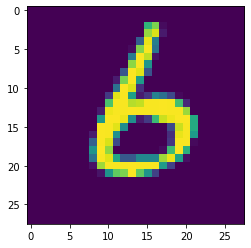

In [5]:
plt.imshow(images[0].numpy().squeeze())

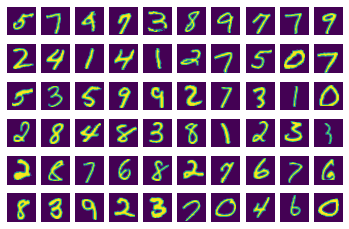

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze())

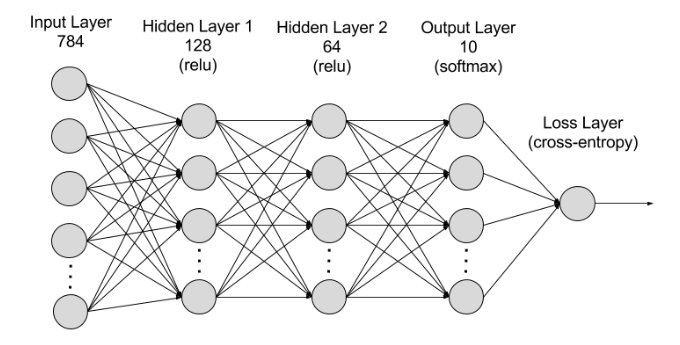

The `nn.Sequential` wraps the layers in the network. There are three linear layers with ReLU activation ( a simple function which allows positive values to pass through, whereas negative values are modified to zero ). The output layer is a linear layer with `LogSoftmax` activation because this is a classification problem.

Technically, a `LogSoftmax` function is the logarithm of a Softmax function as the name says and it looks like this, as shown below.

In [7]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


We define the negative log-likelihood loss

In [8]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [9]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 0.0002,  0.0002,  0.0002,  ...,  0.0002,  0.0002,  0.0002],
        [-0.0006, -0.0006, -0.0006,  ..., -0.0006, -0.0006, -0.0006],
        [-0.0004, -0.0004, -0.0004,  ..., -0.0004, -0.0004, -0.0004],
        ...,
        [ 0.0005,  0.0005,  0.0005,  ...,  0.0005,  0.0005,  0.0005],
        [-0.0002, -0.0002, -0.0002,  ..., -0.0002, -0.0002, -0.0002],
        [-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005]])


/home/akash/.virtualenvs/datascience/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.6359805589768169
Epoch 1 - Training loss: 0.29000223034035677
Epoch 2 - Training loss: 0.23084419024889785
Epoch 3 - Training loss: 0.18252612918472366
Epoch 4 - Training loss: 0.15191533207011693
Epoch 5 - Training loss: 0.12815624822093957
Epoch 6 - Training loss: 0.1132076124458123
Epoch 7 - Training loss: 0.09847048642252808
Epoch 8 - Training loss: 0.08813549824225814
Epoch 9 - Training loss: 0.07923462160223567
Epoch 10 - Training loss: 0.07173020016155772
Epoch 11 - Training loss: 0.06562244403523518
Epoch 12 - Training loss: 0.05960774601204817
Epoch 13 - Training loss: 0.05407179736081503
Epoch 14 - Training loss: 0.05106256183371869

Training Time (in minutes) = 2.4089469075202943


Predicted Digit = 3


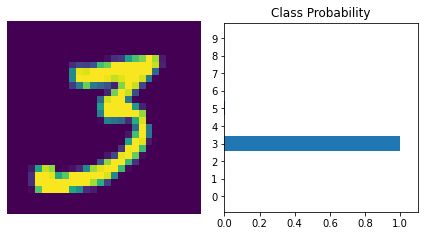

In [19]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [20]:
torch.save(model, './my_mnist_model.pt') 